In [1]:
import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
import sys

# טריק חשוב: הוספת התיקייה השכנה לנתיב כדי שנוכל לייבא את המודל
sys.path.append('../training')
from model import DenoisingAutoencoder

print("Libraries loaded & Model imported successfully!")

Libraries loaded & Model imported successfully!


In [2]:
DATA_DIR = '../data-pipelines/synthetic_data'

def load_dataset():
    # סינון רק לקבצים הנכונים ומיון שיהיו בסדר תואם
    noisy_files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith('noisy')])
    clean_files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith('clean')])
    
    X = [] # קלט (רועש)
    Y = [] # מטרה (נקי)
    
    for nf, cf in zip(noisy_files, clean_files):
        # טעינת האודיו
        n_audio, _ = sf.read(os.path.join(DATA_DIR, nf))
        c_audio, _ = sf.read(os.path.join(DATA_DIR, cf))
        
        # חיתוך אודיו ארוך וריפוד אודיו קצר (כאן נניח שהכל תקין מהסקריפט)
        # המודל מצפה לוקטור באורך 16000 בדיוק
        if len(n_audio) >= 16000:
            X.append(n_audio[:16000])
            Y.append(c_audio[:16000])
            
    return jnp.array(X), jnp.array(Y)

X_train, Y_train = load_dataset()
print(f"Dataset shape: {X_train.shape}") 
# הפלט אמור להיות: (10, 16000)

Dataset shape: (10, 16000)


In [3]:
def create_train_state(rng, learning_rate):
    model = DenoisingAutoencoder()
    # אתחול פרמטרים רנדומליים
    params = model.init(rng, jnp.ones((1, 16000)))['params']
    # בחירת אלגוריתם אופטימיזציה (Adam הוא הסטנדרט)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

@jax.jit # מאיץ את הפונקציה פי 100 בערך
def train_step(state, batch_x, batch_y):
    def loss_fn(params):
        predictions = state.apply_fn({'params': params}, batch_x)
        # פונקציית הטעות: המרחק בין מה שיצא למה שרצינו (MSE)
        loss = jnp.mean((predictions - batch_y) ** 2)
        return loss
    
    # חישוב הנגזרות (Backpropagation)
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    # עדכון המשקולות
    state = state.apply_gradients(grads=grads)
    return state, loss

print("Training logic is ready.")

Training logic is ready.


Starting training...
Epoch 0, Loss: 0.356252
Epoch 50, Loss: 0.001033
Epoch 100, Loss: 0.000006
Epoch 150, Loss: 0.000000
Epoch 200, Loss: 0.000000
Epoch 250, Loss: 0.000000
Epoch 300, Loss: 0.000079
Epoch 350, Loss: 0.000001
Epoch 400, Loss: 0.000000
Epoch 450, Loss: 0.000000


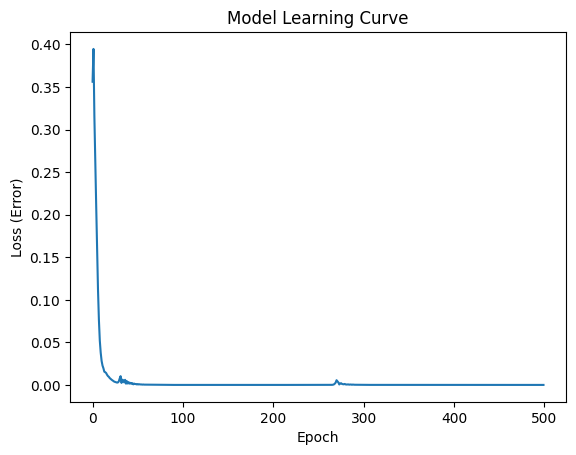

In [4]:
rng = jax.random.PRNGKey(42)
state = create_train_state(rng, learning_rate=0.001)

losses = []
print("Starting training...")

for epoch in range(500): # 500 סיבובים
    state, loss = train_step(state, X_train, Y_train)
    losses.append(loss)
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.6f}')

# גרף הלמידה
plt.plot(losses)
plt.title("Model Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss (Error)")
plt.show()

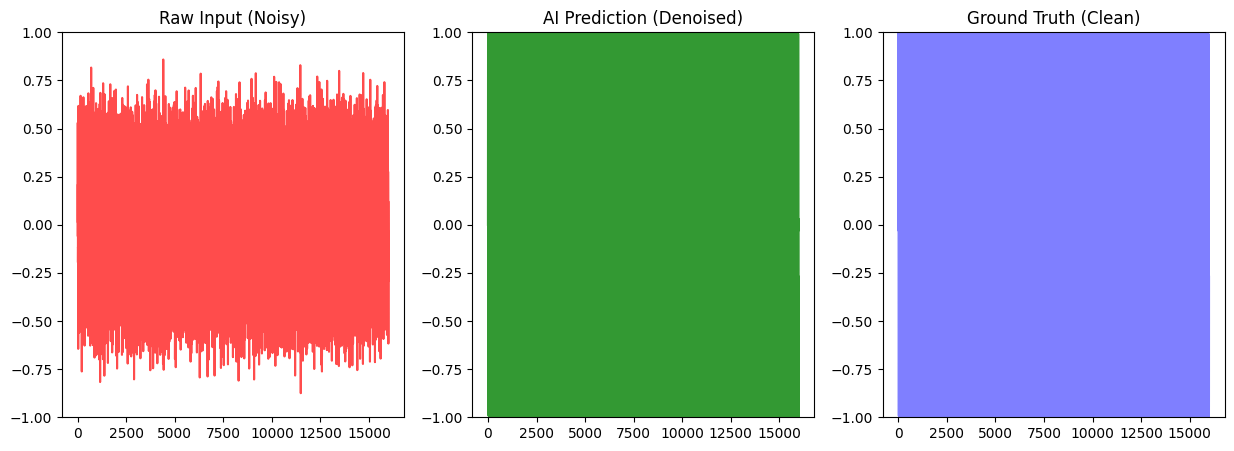

In [5]:
# ניקח דוגמה מהדאטה
sample_idx = 2
noisy_input = X_train[sample_idx:sample_idx+1]

# נבקש מהמודל לנקות אותה
predicted_clean = state.apply_fn({'params': state.params}, noisy_input)

# ציור הגלים
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Raw Input (Noisy)")
plt.plot(noisy_input[0], color='red', alpha=0.7)
plt.ylim(-1, 1)

plt.subplot(1, 3, 2)
plt.title("AI Prediction (Denoised)")
plt.plot(predicted_clean[0], color='green', alpha=0.8)
plt.ylim(-1, 1)

plt.subplot(1, 3, 3)
plt.title("Ground Truth (Clean)")
plt.plot(Y_train[sample_idx], color='blue', alpha=0.5)
plt.ylim(-1, 1)

plt.show()

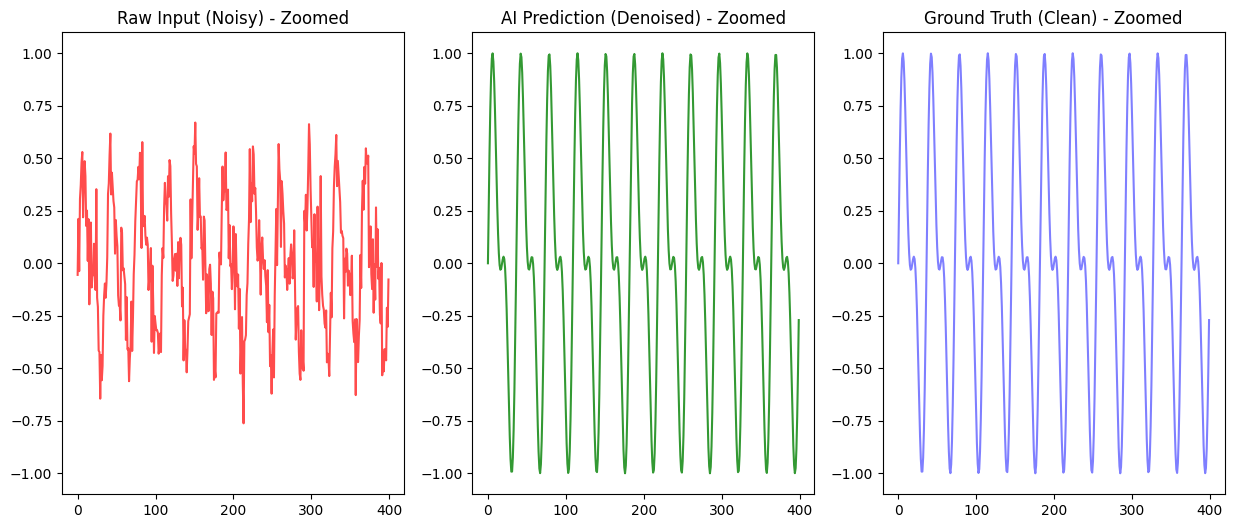

In [6]:
# ניקח דוגמה
sample_idx = 2
noisy_input = X_train[sample_idx:sample_idx+1]
predicted_clean = state.apply_fn({'params': state.params}, noisy_input)

# הגדרת כמות הנקודות לתצוגה (זום)
zoom_start = 0
zoom_end = 400  # נציג רק את 400 הנקודות הראשונות

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("Raw Input (Noisy) - Zoomed")
# שים לב לסוגריים המרובעים בסוף - זה החיתוך
plt.plot(noisy_input[0][zoom_start:zoom_end], color='red', alpha=0.7)
plt.ylim(-1.1, 1.1)

plt.subplot(1, 3, 2)
plt.title("AI Prediction (Denoised) - Zoomed")
plt.plot(predicted_clean[0][zoom_start:zoom_end], color='green', alpha=0.8)
plt.ylim(-1.1, 1.1)

plt.subplot(1, 3, 3)
plt.title("Ground Truth (Clean) - Zoomed")
plt.plot(Y_train[sample_idx][zoom_start:zoom_end], color='blue', alpha=0.5)
plt.ylim(-1.1, 1.1)

plt.show()

In [7]:
from flax import serialization

# הגדרת נתיב השמירה (בתיקיית ה-Training)
save_path = '../training/denoiser_weights.msgpack'

# המרה לבתים (Bytes) ושמירה לקובץ
with open(save_path, 'wb') as f:
    f.write(serialization.to_bytes(state.params))

print(f"Model saved successfully to: {os.path.abspath(save_path)}")

Model saved successfully to: /mnt/d/Eyal/my-startup-repo/ml-core/training/denoiser_weights.msgpack
